In [4]:
## imports

import dask
import fsspec
import gc
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from params import homedir, datadir

plt.style.use('science.mplstyle')
projectdir = '/glade/campaign/uwyo/wyom0112/berkeley/'



In [17]:
snotelmeta = pd.read_csv(homedir + 'data/snotelmeta.csv')
snotel_no_ak = snotelmeta[snotelmeta.state !='AK']
allnames = gcms = ['cesm2','mpi-esm1-2-lr','cnrm-esm2-1',
        'ec-earth3-veg','fgoals-g3','ukesm1-0-ll',
        'canesm5','access-cm2','ec-earth3',]
domain = 'd02'
coords = xr.open_dataset(f'{datadir}meta/meta_new/wrfinput_{domain}')
fulllgcms = {'cesm2':'cesm2_r11i1p1f1_ssp370', 
             'mpi-esm1-2-lr': 'mpi-esm1-2-lr_r7i1p1f1_ssp370',
               'cnrm-esm2-1':'cnrm-esm2-1_r1i1p1f2_ssp370', 
             'ec-earth3-veg':'ec-earth3-veg_r1i1p1f1_ssp370',
               'fgoals-g3':'fgoals-g3_r1i1p1f1_ssp370',
             'ukesm1-0-ll':'ukesm1-0-ll_r2i1p1f2_ssp370',
               'canesm5':'canesm5_r1i1p2f1_ssp370', 
             'access-cm2':'access-cm2_r5i1p1f1_ssp370',
               'ec-earth3':'ec-earth3_r1i1p1f1_ssp370'}

In [6]:
savepath = '/glade/campaign/uwyo/wyom0112/berkeley/'
def find_nearest_indices(lat2d, lon2d, snotel_lat, snotel_lon):
    """Find nearest Euclidean distance indices in 2D grid to latitude-longitude pairs."""
    indices = []
    for i in range (len(snotel_lat)):
        lat = snotel_lat[i]
        lon = snotel_lon[i]
        distances = np.sqrt((lat2d - lat)**2 + (lon2d - lon)**2)
        min_index = np.unravel_index(np.argmin(distances), distances.shape)
        indices.append(min_index)
    return np.array(indices)
snotel_indices = find_nearest_indices(coords['XLAT'][0].values, coords['XLONG'][0].values, snotel_no_ak.lat.values, snotel_no_ak.lon.values)

In [7]:
maxsnotelBC = xr.open_dataset(f'{savepath}/maxsnotelBC.nc')
# maxsnotel = xr.open_dataset(f'{datadir}/maxsnotel.nc')

In [8]:
### PLOTS FOR FIG 1 ###
## load snotel data from stefan values stuff ##
#SNOTEL
snoteldir = homedir
file = snoteldir + "/data/snotel_daily.txt"

ilat = -999
ilon = -999

rec_min = -70.
rec_max = 60.

ind_time = 0
ind_name = 1
ind_sitecode = 2
ind_state = 3
ind_elev = 4
ind_lat = 5
ind_lon = 6
ind_swe = 7
ind_tav = 8
ind_tmax = 9
ind_tmin = 10
ind_acc = 11
ind_prec = 12

ind_swe_qc = 13
ind_swe_qc = 15

ft2m = 12 * 2.54 / 100.
in2mm = 25.4
p49 = 49.
m100 = -100
T0 = 273.15

#Box to mask outsdie Sierra
lat_l = 35.
lat_u = 41.
lon_l = -122.5
lon_u = -116.5

read = open(file, "r")
content = read.readlines()

lat_snotel = []
lon_snotel = []
state_snotel = []
elev_snotel = []
time_snotel = []
site_snotel = []
prec_snotel = []
acc_snotel = []
swe_snotel = []
tav_snotel = []
tmin_snotel = []
tmax_snotel = []
name_snotel = []

lat_snotel_spec = []
lon_snotel_spec = []
elev_snotel_spec = []
site_snotel_spec = []

bad = -9999999
line_count = 1
lat_orig = -999. 

for line in content:
    
 if line.startswith("#") or line.startswith("Date"):
    continue

 else:
  ii = line.split(",")

  if ii[ind_state] == ii[ind_state]:
    time_snotel.append(ii[ind_time])       #Get times
    site_snotel.append(int(ii[ind_sitecode]))       #Get codes
    lat_snotel.append(float(ii[ind_lat]))
    lon_snotel.append(float(ii[ind_lon]))
    elev_snotel.append(float(ii[ind_elev])*ft2m)
    state_snotel.append(ii[ind_state])

   #SWE
    if ii[ind_swe] == "":
     swe_snotel.append(bad)
    if ii[ind_swe] != "":
     swe_x = float(ii[ind_swe])
     swe_snotel.append(swe_x)

    #Temperature
    #There are strange Tav, Tmin, and Tmax values in the data
    #We use reasonable assumptions to get rid of them
    # 1. If one is missing, eliminate them all
    # 2. Remove instances where Tmax = Tmin, Tmax = Tav, Tmax = Tmin
    # 3. Eliminate *rcords*
    
    switch = "on" #if on, raw SNOTEL data is appended
    
    #1.
    if ii[ind_tav] == "" or ii[ind_tmin] == "" or ii[ind_tmax] == "":
     tav_snotel.append(bad)
     tmax_snotel.append(bad)
     tmin_snotel.append(bad)
     switch = "off"

    if ii[ind_tav] != "" and ii[ind_tmin] != "" and ii[ind_tmax] != "":
     tav = float (ii[ind_tav])
     tmax = float (ii[ind_tmax])
     tmin = float (ii[ind_tmin])

     #2.
     dt1 = tmax - tmin
     dt2 = tmax - tav
     dt3 = tmin - tav
        
     if dt1 < 0 or dt2 < 0 or dt3 > 0:
      if switch == "on":        #This switch ensures no double-dipping
       tav_snotel.append(bad)   #"Just take one dip, and end it!!!"
       tmax_snotel.append(bad)
       tmin_snotel.append(bad)        
       switch = "off"

     #3.
     if tmax < rec_min or tav < rec_min or tmin < rec_min:    
      if switch == "on":
       tav_snotel.append(bad)
       tmax_snotel.append(bad)
       tmin_snotel.append(bad)
       switch = "off"
    
     if tmax > rec_max or tav > rec_max or tmin > rec_max:
      if switch == "on":
       tav_snotel.append(bad)
       tmax_snotel.append(bad)
       tmin_snotel.append(bad) 
       switch = "off"

     if switch == "on":
        tav_snotel.append(tav)
        tmax_snotel.append(tmax)
        tmin_snotel.append(tmin)

    #Acc. precip
    if ii[ind_acc] == "":
     acc_snotel.append(bad)
    if ii[ind_acc] != "":
     acc_x = float(ii[ind_acc])
     acc_snotel.append(acc_x)
    
     #Prec
    if ii[ind_prec] == "" or ii[ind_prec] == "\n":
     prec_snotel.append(bad)
    else:
     prec_mm = float(ii[ind_prec])
     prec_snotel.append(prec_mm)

    #Checks
    if float(ii[ind_lat]) != lat_orig:
     lat_snotel_spec.append(float(ii[ind_lat]))
     lon_snotel_spec.append(float(ii[ind_lon]))
     elev_snotel_spec.append(float(ii[ind_elev])*ft2m)
     site_snotel_spec.append(int(ii[ind_sitecode]))

     lat_orig =  float(ii[ind_lat])
        
snotel_day = pd.to_datetime(time_snotel, format='%Y-%m-%d')

#Convert to DataArray
swe_snotel = xr.DataArray(swe_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day), 
                                                              'z':( ['x'],elev_snotel), 
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})
prec_snotel = xr.DataArray(prec_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day),
                                                              'z':( ['x'],elev_snotel), 
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})
tave_snotel = xr.DataArray(tav_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day), 
                                                              'z':( ['x'],elev_snotel), 
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})
tmin_snotel = xr.DataArray(tmin_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day), 
                                                              'z':( ['x'],elev_snotel), 
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})
tmax_snotel = xr.DataArray(tmax_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day), 
                                                              'z':( ['x'],elev_snotel), 
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})
acc_snotel = xr.DataArray(acc_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day),
                                                              'z':( ['x'],elev_snotel),
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})

#Meta array for all SNOTEL sites
meta_snotel = xr.DataArray(elev_snotel_spec,dims=['site'],coords={'site':( ['site'],site_snotel_spec), 
                                                              'lat':( ['site'],lat_snotel_spec),
                                                              'lon':( ['site'],lon_snotel_spec)})


print (len(lat_snotel_spec), len(lon_snotel_spec), len(elev_snotel_spec), len(site_snotel_spec))

print (prec_snotel)

print ("CONUS SNOTEL array generated")

gc.collect()

111 111 111 111
<xarray.DataArray (x: 577172)>
array([3., 0., 3., ..., 0., 0., 0.])
Coordinates:
    site     (x) int64 308 308 308 308 308 308 308 ... 784 784 784 784 784 784
    time     (x) datetime64[ns] 2019-09-02 2019-09-03 ... 2011-04-29 2011-04-30
    z        (x) float64 2.225e+03 2.225e+03 2.225e+03 ... 2.442e+03 2.442e+03
    state    (x) <U10 'ARIZONA' 'ARIZONA' ... 'CALIFORNIA' 'CALIFORNIA'
    lat      (x) float64 34.46 34.46 34.46 34.46 ... 39.19 39.19 39.19 39.19
    lon      (x) float64 -111.4 -111.4 -111.4 -111.4 ... -120.3 -120.3 -120.3
Dimensions without coordinates: x
CONUS SNOTEL array generated


0

In [9]:
snow_SNOTELfromWRF_BC = xr.open_dataset(f'{savepath}/snow_SNOTELfromWRF_BC.nc')

In [10]:
date_start_hist, date_end_hist = "1980-09-01", "2014-08-31"
date_start_ssp, date_end_ssp = "2014-09-01", "2100-08-31"
snw_snotel_cesm2 = snow_SNOTELfromWRF_BC.sel(gcm = 'cesm2_r11i1p1f1_ssp370').sel(time=slice(date_start_hist,date_end_hist))

In [14]:
monthly = snw_snotel_cesm2.groupby(snw_snotel_cesm2.time.dt.month).mean()['snow'].mean(dim = 'site')


In [33]:
## load globsnow data
mydir = '/glade/u/home/mcowherd/snow_drought/downscaling/'
globsnow_bc = xr.open_dataset(mydir + 'globsnow_bc_no_ak.nc')
era5 = xr.open_dataset(mydir + 'era5_no_ak.nc')

/glade/scratch/mcowherd/ipykernel_241113/1999840576.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(era5.longitude, era5.latitude, np.nansum(era5['sd'], axis =0))


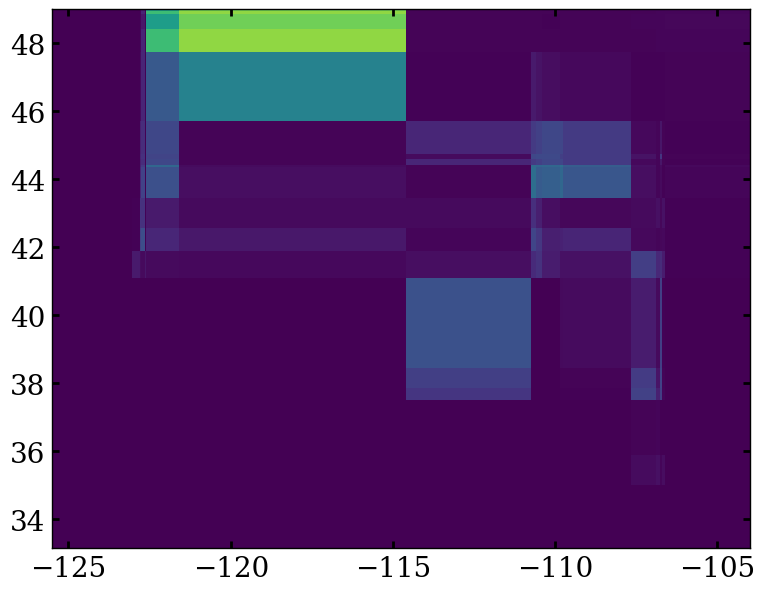

In [40]:
plt.pcolormesh(era5.longitude, era5.latitude, np.nansum(era5['sd'], axis =0))

In [41]:
globsnow_bc

<xarray.Dataset>
Dimensions:  (month: 4, y: 824, x: 824)
Coordinates:
  * x        (x) float64 -5.515e+06 -5.54e+06 ... -4.612e+06 -4.688e+06
  * y        (y) float64 2.156e+06 2.156e+06 2.005e+06 ... 1.654e+06 1.68e+06
  * month    (month) int64 2 3 4 5
Data variables:
    swe      (month, y, x) float64 ...
Attributes: (12/42)
    title:                      ESA GlobSnow SWE biascorrected monthly product
    institution:                FMI
    source:                     SSMI brightness temperature data from 19 & 37...
    history:                    20201102T115725Z: ESA GlobSnow SWE v 3.0 proc...
    references:                 http://www.globsnow.info/
    tracking_id:                d747b10f-db09-438e-a8dd-22a855eacde9
    ...                         ...
    license:                    CC-BY: Creative Commons Attribution 4.0 Inter...
    platform:                   DMSP F11
    sensor:                     SSM/I
    spatial_resolution:         0.25 degree
    key_variables:              swe
    doi:                        doi:10.1594/PANGAEA.911944

/glade/scratch/mcowherd/ipykernel_241113/2847959146.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(globsnow_bc.x, globsnow_bc.y, globsnow_bc['swe'][1])


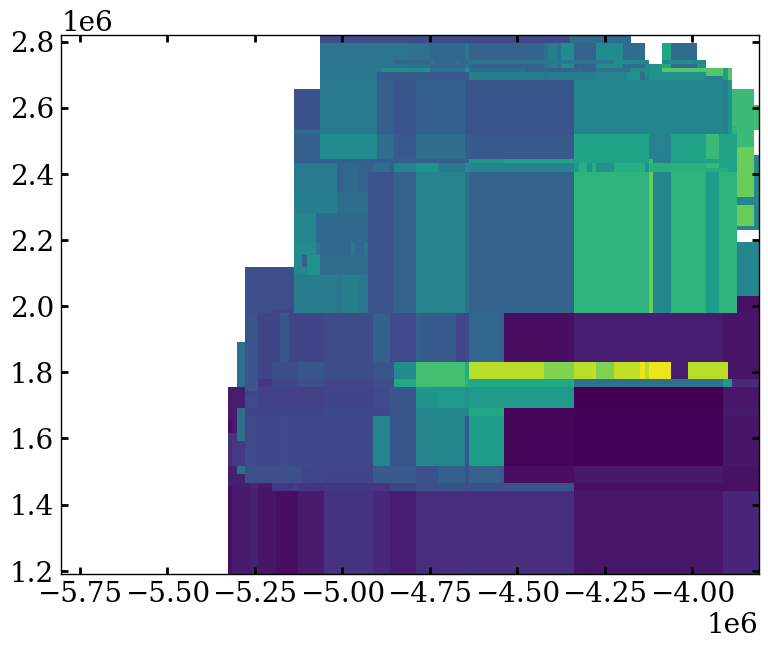

In [45]:
plt.pcolormesh(globsnow_bc.x, globsnow_bc.y, globsnow_bc['swe'][1]) ## is this utms?


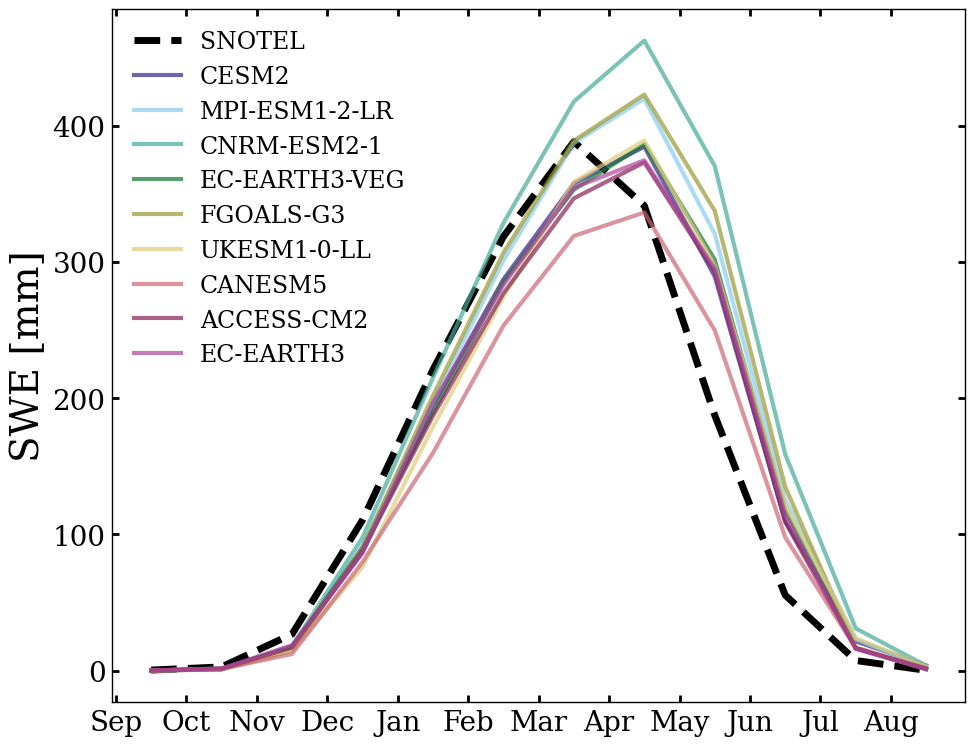

In [47]:
## just the snotel sites ##
## need to add something bc/nonbc
domain = 'd02'

months = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
nums = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5]
fig,ax=plt.subplots(figsize=(11,9))
swe_snotel[swe_snotel <0] = np.nan
snotel_data = swe_snotel.groupby(swe_snotel.time.dt.month).mean()
ax.plot(nums, np.roll(snotel_data,4),'--', linewidth = 5, alpha = 1, label = 'SNOTEL')
models_snw_arrs = []
for key in allnames:
    name = fulllgcms[key]
    snw_data = xr.open_dataset(glob.glob(savepath + f'snow_{key}*_{domain}_BC.nc')[0])
    models_snw_arrs.append(snw_data)
    snw_snotel = snow_SNOTELfromWRF_BC.sel(gcm = name).sel(time=slice(date_start_hist,date_end_hist))
    monthly = snw_snotel.groupby(snw_snotel.time.dt.month).mean()['snow'].mean(dim = 'site')
    ax.plot(nums, np.roll(monthly.data,4), label = key.upper(), linewidth = 3, alpha = 0.7)
    
ax.set_xticks(range(0,12))
ax.set_xticklabels(months)
ax.set_ylabel(r'SWE [mm]')
ax.legend()
plt.show()
# fig.savefig('fig1_downscale.jpg')

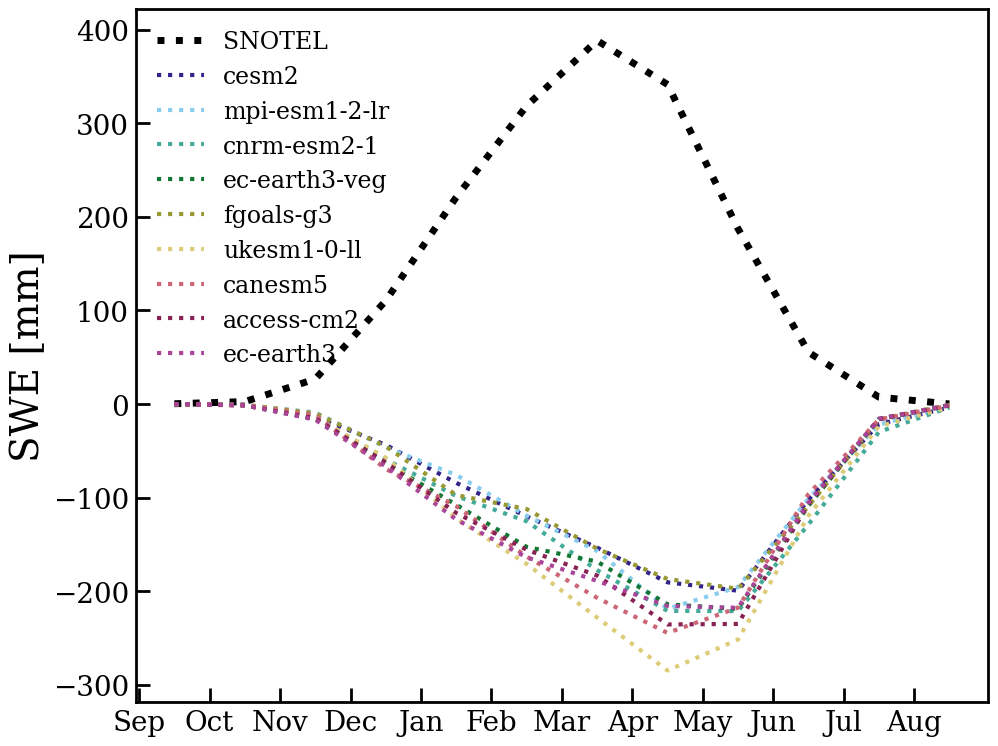

In [66]:
## just the snotel sites ##
## need to add something bc/nonbc
domain = 'd02' ## doesnt matter en
colorslist = ["black", "#332288","#88CCEE","#44AA99","#117733","#999933","#DDCC77","#CC6677","#882255","#AA4499","brown","#fd3c06","gray"]

date_start_hist, date_end_hist = "1980-09-01", "2014-08-31"
date_start_eoc, date_end_eoc = "2070-09-01", "2100-08-31"

months = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
nums = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5]
fig,ax=plt.subplots(figsize=(11,9))
swe_snotel[swe_snotel <0] = np.nan
snotel_data = swe_snotel.groupby(swe_snotel.time.dt.month).mean()
ax.plot(nums, np.roll(snotel_data,4),':', linewidth = 5, alpha = 1, label = 'SNOTEL')


models_snw_arrs = []
for i,key in enumerate(allnames):
    name = fulllgcms[key]
    snw_snotel_hist = snow_SNOTELfromWRF_BC.sel(gcm = name).sel(time=slice(date_start_hist,date_end_hist))
    snw_snotel_eoc = snow_SNOTELfromWRF_BC.sel(gcm = name).sel(time=slice(date_start_eoc, date_end_eoc ))
    monthly_hist= snw_snotel_hist.groupby(snw_snotel_hist.time.dt.month).mean()['__xarray_dataarray_variable__'].mean(dim = 'site')
    monthly_eoc = snw_snotel_eoc.groupby(snw_snotel_eoc.time.dt.month).mean()['__xarray_dataarray_variable__'].mean(dim = 'site')
    monthly_diff = monthly_eoc  - monthly_hist
    #ax.plot(nums, np.roll(monthly_hist.data,4), '-',label = key, linewidth = 3, alpha = 0.6, color = colorslist[i+1])
    ax.plot(nums, np.roll(monthly_diff.data,4), ':',label = key, linewidth = 3,color = colorslist[i+1])
    
ax.set_xticks(range(0,12))
ax.set_xticklabels(months)
ax.set_ylabel(r'SWE [mm]')
ax.legend()
plt.show()


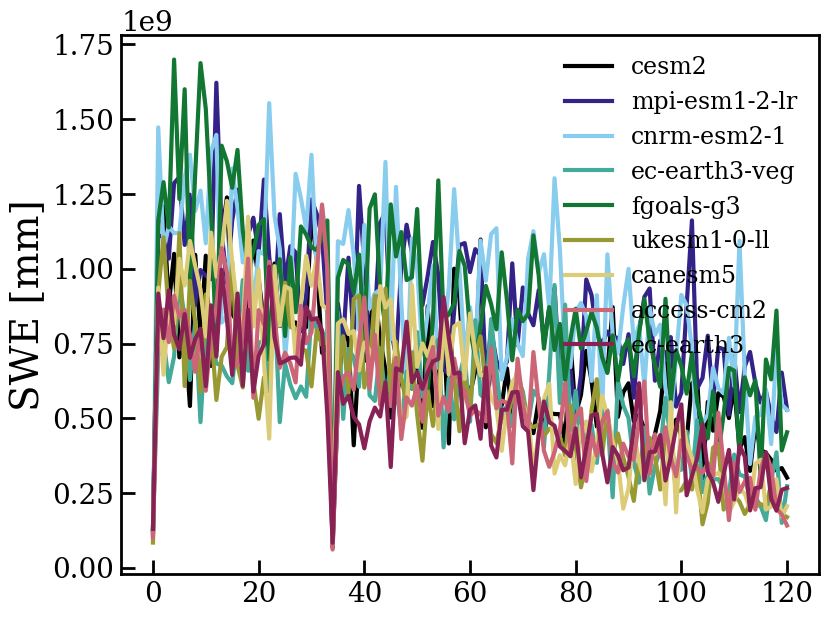

In [48]:
fig, ax = plt.subplots()
models_snw_arrs = []
for key in allnames:
    snw_data = xr.open_dataset(glob.glob(savepath + f'snow_{key}*_{domain}.nc')[0]) 
    models_snw_arrs.append(snw_data)
    yearly_sum = snw_data.groupby(snw_data.time.dt.year).sum()
    tssum = np.nansum(yearly_sum['snow'], axis = (1,2))
    ax.plot(tssum, label = key, linewidth = 3)
ax.set_ylabel(r'SWE [mm]')
ax.legend()
plt.show()


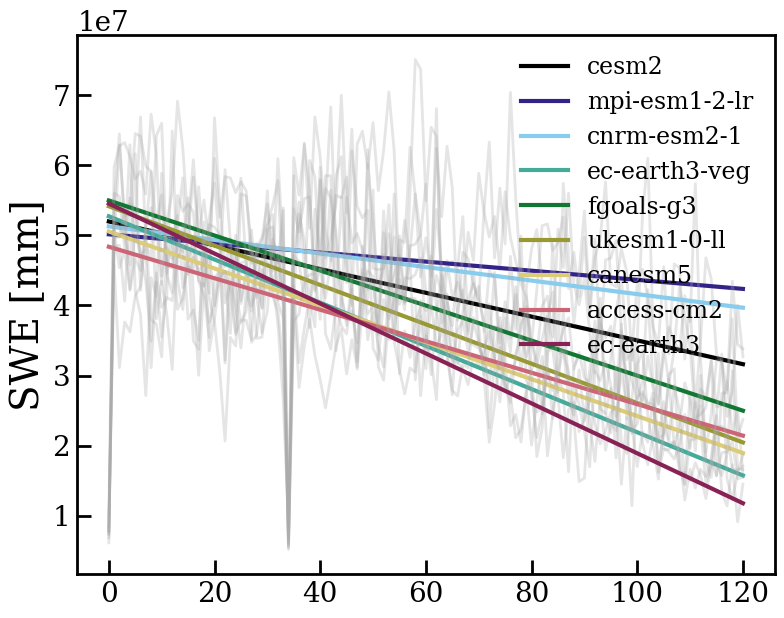

In [90]:
from scipy.stats import theilslopes
x = np.arange(121)

domain = 'd01'
bc = 'BC'
fig, ax = plt.subplots()
models_snw_arrs = []
for key in allnames:
    snw_data = xr.open_dataset(glob.glob(savepath + f'snow_{key}*_{domain}_{bc}.nc')[0]) 
    models_snw_arrs.append(snw_data)
    yearly_sum = snw_data.groupby(snw_data.time.dt.year).sum()
    tssum = np.nansum(yearly_sum['snow'], axis = (1,2))
    ax.plot(x, tssum, color = 'darkgray', alpha = 0.3)
    slope, intercept, _, _ = theilslopes(tssum, x)
    trendline = intercept + slope * x
    ax.plot(x, trendline, label = key, linewidth = 3)
ax.set_ylabel(r'SWE [mm]')
ax.legend()
plt.show()

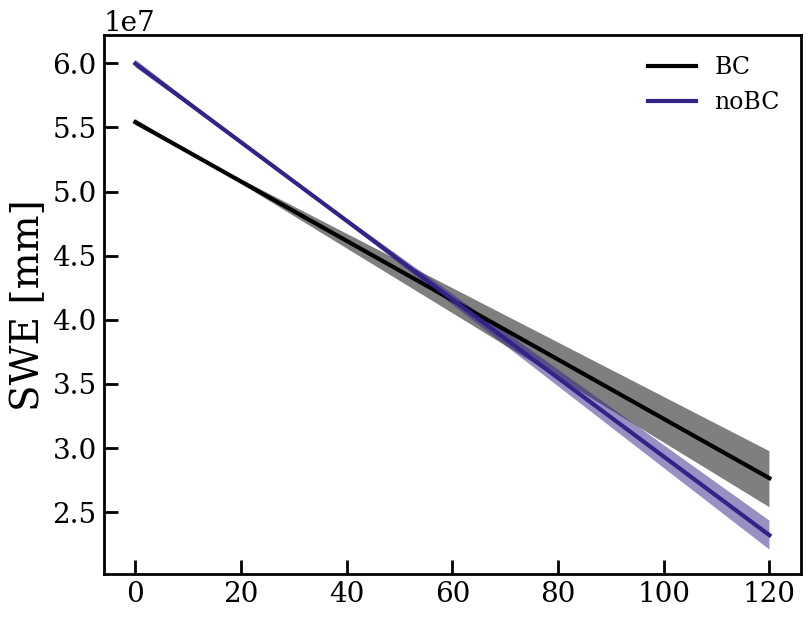

In [92]:
from scipy.stats import theilslopes
x = np.arange(121)

domain = 'd01'
bc = 'noBC'
fig, ax = plt.subplots()
mean_info = []

for bc in ['BC', 'noBC']:
    mydata = []
    for key in allnames:
        snw_data = xr.open_dataset(glob.glob(savepath + f'snow_{key}*_{domain}_{bc}.nc')[0]) 
        models_snw_arrs.append(snw_data)
        yearly_sum = snw_data.groupby(snw_data.time.dt.year).sum()
        tssum = np.nansum(yearly_sum['snow'], axis = (1,2))
        mydata.append(tssum)
    allmydata = np.nanmean(np.array(mydata), axis = 0)
    slope, intercept, lowslope, highslope = theilslopes(allmydata, x)
    trendline = intercept + slope * x
    ax.plot(x, trendline, label = bc, linewidth = 3)
    lower_bound = intercept - lowslope + lowslope * x
    upper_bound = intercept + highslope + highslope * x
    ax.fill_between(x, lower_bound, upper_bound, alpha = 0.5)
    mean_info.append([x, trendline, intercept, lowslope, highslope])
ax.set_ylabel(r'SWE [mm]')
ax.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
for i, data in enumerate(mean_info):
    x, trendline, intercept, lowslope, highslope = data
    ax.plot(x, trendline, label = bc, linewidth = 3)
    #lower_bound = intercept - lowslope*len(x) + lowslope * x
    #upper_bound = intercept + highslope*len(x) + highslope * x
    #ax.fill_between(x, lower_bound, upper_bound, alpha = 0.5)
ax.set_ylabel(r'SWE [mm]')
ax.legend()
plt.show()

## from scipy.stats import theilslopes
x = np.arange(121)


fig, ax = plt.subplots()
models_snw_arrs = []
for key in allnames:
    snw_data = xr.open_dataset(glob.glob(savepath + f'snow_{key}*_{domain}.nc')[0]) 
    models_snw_arrs.append(snw_data)
    yearly_sum = snw_data.groupby(snw_data.time.dt.year).sum()
    tssum = np.nansum(yearly_sum['snow'], axis = (1,2))
    slope, intercept, _, _, _ = theilslopes(tssum, x)
    trendline = intercept + slope * x
    ax.plot(x, trendline = key, linewidth = 3)
ax.set_ylabel(r'SWE [mm]')
ax.legend()
plt.show()